# Naver Movie Review - Sentiment Classification

#### Step 1. Data File
- 데이터 파일 준비
- 데이터 로더

#### Step 2. Data Setting
- 인코딩과 디코딩
- 데이터 크기 조정
- 데이터 분리 (훈련/검증)

#### Step 3. Model
- LSTM
- cov1D
- cov2D

#### Step 4. Evaluation
- 오차와 정확도
- 임베딩 분석 (유사단어)

#### Step 5. Tranfer Learning
- Word2Vec
- Model
- 오차와 정확도
- 임베딩 분석 (유사단어)
- 최종 결과

### 모듈 리스트

In [56]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab # tokenizer
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors # embedding
import gensim
from tensorflow.keras.initializers import Constant

## Data File

### 데이터 파일 준비

In [57]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [58]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [59]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 데이터 로더

#### 불용어

In [60]:
stopwords = ['은', '는', '이', '가', '들', '을', '를', '하다', '요', '에', '으로', '다', '고', '하', '의', '있', '게', '수', '았', \
             '네', '겠', '되', '해', '습니다', '할', '것', '싶', '듯', '함', '해서', '임', '입니다', '으면', '네요', '예요']

#### 토크나이저

In [61]:
tokenizer = Mecab()

#### 로드 데이터 함수

In [62]:
def load_data(train_data, test_data, num_words = 10000):
    # 중복, NAN 제거
    train_data = train_data.drop_duplicates(subset = ['document'])
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.drop_duplicates(subset = ['document'])
    test_data = test_data.dropna(how = 'any')
    
    # 토큰화 및 불용어 제거
    def tokenize(data):
        X = []
        for doc in data['document']:
            temp_X = tokenizer.morphs(doc)
            temp_X = [word for word in temp_X if not word in stopwords]
            X.append(temp_X)
            
        return X
    
    X_train = tokenize(train_data)
    X_test = tokenize(test_data)
    
    # 사전 word to index
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000 - 4) # UNK, BOS, PAD
    vocab = ["", "", "", ""] + [key for key, num in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    word_to_index['<PAD>'] = 0
    word_to_index['<BOS>'] = 1
    word_to_index['<UNK>'] = 2
    
    # text -> index
    def to_indexlist(wordlist):
        return [1] + [word_to_index[word] if word in word_to_index else word_to_index[""] for word in wordlist]
    
    X_train = list(map(to_indexlist, X_train))
    X_test = list(map(to_indexlist, X_test))
    
    # 리턴 정의
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    
    return X_train, y_train, X_test, y_test, word_to_index

In [63]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [64]:
index_to_word = {index:word for word, index in word_to_index.items()}

## Data Setting

### 인코딩과 디코딩

In [65]:
# sentence -> index vector
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# sentences -> index vector
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]
 
# index vector -> sentence
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])
# index vector -> sentences 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [66]:
# 미리보기
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))

[1, 27, 63, 902, 4, 4, 33, 211, 16, 732]
아 더 빙 . . 진짜 짜증 나 목소리


### 데이터 크기 조정

#### 적절한 토큰의 수 구하기

In [67]:
# 훈련 데이터와 시험 데이터 합
X_all = list(X_train) + list(X_test)

# 문장별 단어 개수 리스트
num_tokens = [len(tokens) for tokens in X_all]

# 통계값
num_tokens = pd.DataFrame(num_tokens)
print(num_tokens.describe())

# 전체 데이터의 95%를 포함하는 토큰의 수
maxlen = int(num_tokens.quantile(0.95))
print("\n전체 데이터의 95%가 토큰의 수 {} 미만".format(maxlen))

                   0
count  195339.000000
mean       15.417961
std        11.537582
min         1.000000
25%         8.000000
50%        12.000000
75%        18.000000
max       117.000000

전체 데이터의 95%가 토큰의 수 43 미만


#### 패딩하여 토큰의 수 통일

In [68]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

### 데이터 분리 (훈련/검증)

In [69]:
# 훈련 데이터의 20% 
quot = int(len(X_train) * 0.2)

X_val = X_train[:quot]
y_val = y_train[:quot]

X_train = X_train[quot:]
y_train = y_train[quot:]

## Model

In [70]:
vocab_size = 10000
word_vector_dim = 16

### LSTM

#### 모델 설계

In [71]:
LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
LSTM_model.add(tf.keras.layers.LSTM(32))
LSTM_model.add(tf.keras.layers.Dense(32, activation = 'relu'))
LSTM_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

LSTM_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
_________________________________________________________________


#### 훈련

In [72]:
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_history = LSTM_model.fit(X_train, y_train, epochs = 10, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
229/229 [==============================] - 3s 7ms/step - loss: 0.4674 - accuracy: 0.7744 - val_loss: 0.3508 - val_accuracy: 0.8484
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3353 - accuracy: 0.8575 - val_loss: 0.3432 - val_accuracy: 0.8525
Epoch 3/10
229/229 [==============================] - 1s 5ms/step - loss: 0.3152 - accuracy: 0.8685 - val_loss: 0.3458 - val_accuracy: 0.8513
Epoch 4/10
229/229 [==============================] - 1s 5ms/step - loss: 0.3009 - accuracy: 0.8749 - val_loss: 0.3425 - val_accuracy: 0.8512
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2873 - accuracy: 0.8809 - val_loss: 0.3427 - val_accuracy: 0.8539
Epoch 6/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2736 - accuracy: 0.8869 - val_loss: 0.3478 - val_accuracy: 0.8532
Epoch 7/10
229/229 [==============================] - 1s 5ms/step - loss: 0.2600 - accuracy: 0.8932 - val_loss: 0.3563 - val_accuracy: 0.8543
Epoch 

### Conv1D

#### 모델 설계

In [73]:
Conv1D_model = tf.keras.Sequential()
Conv1D_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
Conv1D_model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
Conv1D_model.add(tf.keras.layers.MaxPooling1D(5))
Conv1D_model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
Conv1D_model.add(tf.keras.layers.GlobalMaxPooling1D())
Conv1D_model.add(tf.keras.layers.Dense(8, activation = 'relu'))
Conv1D_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) 

Conv1D_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

#### 훈련

In [74]:
Conv1D_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
Conv1D_history = Conv1D_model.fit(X_train, y_train, epochs = 20, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 5ms/step - loss: 0.5396 - accuracy: 0.7108 - val_loss: 0.4179 - val_accuracy: 0.8019
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3890 - accuracy: 0.8224 - val_loss: 0.4038 - val_accuracy: 0.8076
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3561 - accuracy: 0.8404 - val_loss: 0.4034 - val_accuracy: 0.8107
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3304 - accuracy: 0.8542 - val_loss: 0.4082 - val_accuracy: 0.8102
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3026 - accuracy: 0.8689 - val_loss: 0.4189 - val_accuracy: 0.8075
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2733 - accuracy: 0.8830 - val_loss: 0.4431 - val_accuracy: 0.8033
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2421 - accuracy: 0.8988 - val_loss: 0.4709 - val_accuracy: 0.8006
Epoch 

### GlobalMaxPooling

#### 모델 설계

In [75]:
GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation = 'relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))  

GMP_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


#### 훈련

In [76]:
GMP_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
GMP_history = GMP_model.fit(X_train, y_train, epochs = 10, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
229/229 [==============================] - 1s 4ms/step - loss: 0.5952 - accuracy: 0.7466 - val_loss: 0.4367 - val_accuracy: 0.8152
Epoch 2/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3782 - accuracy: 0.8391 - val_loss: 0.3589 - val_accuracy: 0.8416
Epoch 3/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3248 - accuracy: 0.8630 - val_loss: 0.3479 - val_accuracy: 0.8476
Epoch 4/10
229/229 [==============================] - 1s 3ms/step - loss: 0.2968 - accuracy: 0.8773 - val_loss: 0.3482 - val_accuracy: 0.8496
Epoch 5/10
229/229 [==============================] - 1s 3ms/step - loss: 0.2763 - accuracy: 0.8872 - val_loss: 0.3523 - val_accuracy: 0.8504
Epoch 6/10
229/229 [==============================] - 1s 3ms/step - loss: 0.2595 - accuracy: 0.8949 - val_loss: 0.3598 - val_accuracy: 0.8500
Epoch 7/10
229/229 [==============================] - 1s 3ms/step - loss: 0.2450 - accuracy: 0.9023 - val_loss: 0.3671 - val_accuracy: 0.8485
Epoch 

## Evaluation

### 오차와 정확도

In [77]:
# 그래프를 그리는 함수
def show_plt(model_history):
    history_dict = model_history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1, 2, figsize = (12, 4))

    ax[0].plot(epochs, loss, 'bo', label='Training loss')
    ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(0, 1.1)
    ax[0].legend()

    ax[1].plot(epochs, acc, 'bo', label='Training acc')
    ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0.7, 1.0)
    ax[1].legend()

    plt.show()

#### LSTM

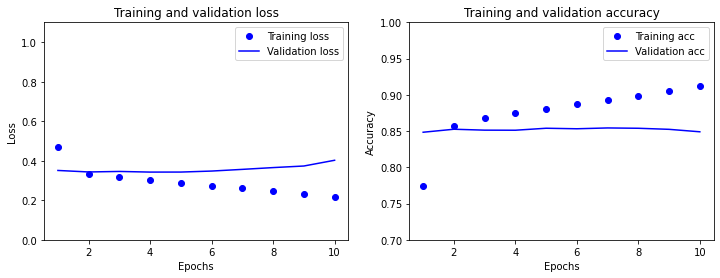

In [78]:
show_plt(LSTM_history)

* validation loss, acc가 training loss, acc와 차이가 큼
* validation loss가 증가 추세

#### Conv1D

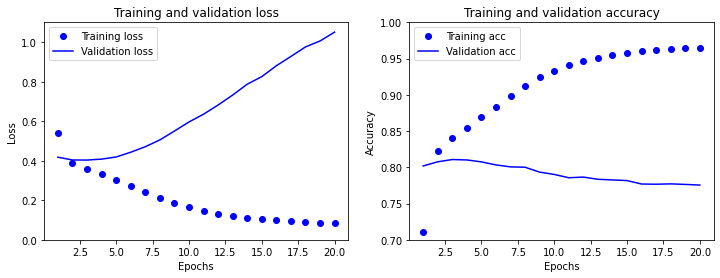

In [79]:
show_plt(Conv1D_history)

* validation loss, acc가 training loss, acc와 격차가 커지는 경향
* validation loss가 증가 추세

#### GlobalMaxPooling

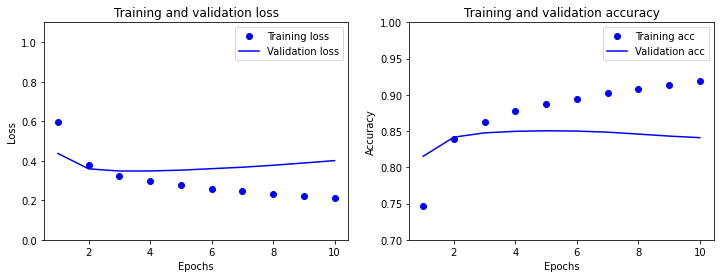

In [80]:
show_plt(GMP_history)

* validation loss가 training loss와 격차가 커지는 경향
* validation loss가 증가 추세
* 세 모델 중 가장 안정적

### 임베딩 분석 (유사단어)

In [81]:
# 유사단어 보기 함수
def check_wordvec(model):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    
    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
    
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    
    for i in [43, 60, 81]:
        print("word:", index_to_word[i])
        print("result")
        print(word_vectors.similar_by_word(index_to_word[i]))
        print()
    

#### LSTM

In [82]:
check_wordvec(LSTM_model)

word: 연기
result
[('동화책', 0.8845469355583191), ('청순', 0.8457924127578735), ('특히', 0.8242980241775513), ('예기', 0.8215144276618958), ('니다', 0.8214177489280701), ('인상', 0.8194613456726074), ('전설', 0.8148647546768188), ('슬픈', 0.8136781454086304), ('마블', 0.8125299215316772), ('단연', 0.8088964223861694)]

word: 드라마
result
[('ㅜㅜ', 0.8906786441802979), ('!!!', 0.8599756956100464), ('고요', 0.8398851752281189), ('무서움', 0.8358830213546753), ('정우성', 0.8278054594993591), ('나락', 0.8253262042999268), ('으실', 0.8246469497680664), ('참고', 0.8190872669219971), ('2006', 0.8187699317932129), ('슈퍼맨', 0.8170325756072998)]

word: 재미
result
[('그리워', 0.903413712978363), ('십시오', 0.8518449664115906), ('오브', 0.8353012800216675), ('닿', 0.8314346075057983), ('느', 0.8154278993606567), ('절묘', 0.8084152936935425), ('들어가', 0.8073796629905701), ('of', 0.8064407110214233), ('똘똘', 0.8049975633621216), ('징', 0.8007650375366211)]



- 유사한 단어도 있으나 대체로 유사하지 않음

#### Conv1D

In [83]:
check_wordvec(Conv1D_model)

word: 연기
result
[('움직인다', 0.8270346522331238), ('과', 0.8196890354156494), ('이뤄', 0.8060828447341919), ('닥치', 0.7919548153877258), ('아무튼', 0.7905275225639343), ('저런', 0.7783456444740295), ('창조', 0.7738627195358276), ('모두', 0.7736384868621826), ('프리퀄', 0.772047758102417), ('드니로', 0.7634190320968628)]

word: 드라마
result
[('아동', 0.755155086517334), ('오', 0.7402740120887756), ('아시아', 0.7344199419021606), ('시급', 0.7217013239860535), ('도라에몽', 0.6820083260536194), ('어서', 0.6609355211257935), ('대결', 0.6595584154129028), ('꾼', 0.6564829349517822), ('해선', 0.6516584753990173), ('2013', 0.645388126373291)]

word: 재미
result
[('박중훈', 0.8558659553527832), ('툭툭', 0.788077712059021), ('유', 0.775661051273346), ('임수정', 0.7701240181922913), ('겁나', 0.7550921440124512), ('엉뚱', 0.7407786250114441), ('리얼리티', 0.7384821176528931), ('브란도', 0.7337340116500854), ('농담', 0.7303959131240845), ('같', 0.723671555519104)]



- 유사한 단어도 있으나 대체로 유사하지 않음

#### GlobalMaxPooling

In [84]:
check_wordvec(GMP_model)

word: 연기
result
[('내내', 0.9701261520385742), ('기대', 0.9686275124549866), ('터지', 0.9631402492523193), ('그대로', 0.9589839577674866), ('음', 0.9528669714927673), ('초심', 0.9513070583343506), ('완전', 0.9498735666275024), ('랑', 0.9494739174842834), ('어쩌구', 0.9441559314727783), ('나', 0.9438778162002563)]

word: 드라마
result
[('선사', 0.9319007396697998), ('중', 0.9303934574127197), ('브래드', 0.9247533082962036), ('딘', 0.9226329326629639), ('했어요', 0.9183529615402222), ('는데', 0.9164761304855347), ('대요', 0.9028365612030029), ('스타일', 0.8997797966003418), ('냉소', 0.8970824480056763), ('개인', 0.8946462869644165)]

word: 재미
result
[('버', 0.8239479660987854), ('아이디어', 0.7978070378303528), ('간간히', 0.786879301071167), ('치명', 0.7834739089012146), ('미국', 0.7793779373168945), ('모차르트', 0.7771815061569214), ('쥬라기', 0.77373206615448), ('여우', 0.7730121612548828), ('ㄷ', 0.7651939392089844), ('재', 0.7643573880195618)]



- 유사성을 찾을 수 없음

## Tranfer Learning

### Word2Vec

In [85]:
word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [86]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1488/2448617487.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1488/2448617487.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### Model

In [87]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), \
                                    input_length=maxlen, trainable=True))   
model.add(tf.keras.layers.LSTM(512))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) 

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 43, 200)           2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 513       
Total params: 3,723,393
Trainable params: 3,723,393
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 5, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/5
229/229 [==============================] - 17s 67ms/step - loss: 0.4418 - accuracy: 0.7905 - val_loss: 0.3478 - val_accuracy: 0.8476
Epoch 2/5
229/229 [==============================] - 15s 66ms/step - loss: 0.3149 - accuracy: 0.8634 - val_loss: 0.3258 - val_accuracy: 0.8594
Epoch 3/5
229/229 [==============================] - 15s 66ms/step - loss: 0.2662 - accuracy: 0.8878 - val_loss: 0.3306 - val_accuracy: 0.8628
Epoch 4/5
229/229 [==============================] - 15s 66ms/step - loss: 0.2260 - accuracy: 0.9059 - val_loss: 0.3194 - val_accuracy: 0.8679
Epoch 5/5
229/229 [==============================] - 15s 66ms/step - loss: 0.1819 - accuracy: 0.9256 - val_loss: 0.3539 - val_accuracy: 0.8633


### 오차와 정확도

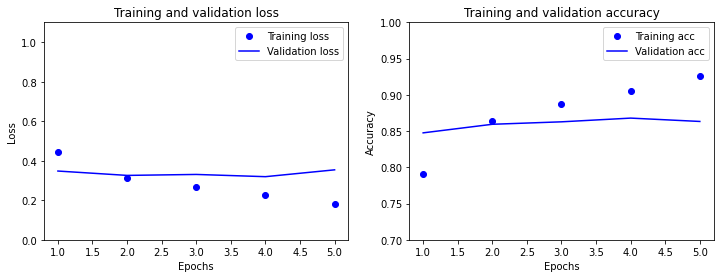

In [89]:
show_plt(history)

### 임베딩 분석 (유사단어)

In [90]:
check_wordvec(model)

word: 연기
result
[('연출', 0.5079755783081055), ('주연', 0.4581282436847687), ('출연', 0.4572628140449524), ('캐스팅', 0.4369467794895172), ('조연', 0.42432963848114014), ('단역', 0.4139786958694458), ('냄새', 0.4119061529636383), ('패러디', 0.40646904706954956), ('배역', 0.4011685252189636), ('성우', 0.38346096873283386)]

word: 드라마
result
[('시트콤', 0.7960419654846191), ('다큐멘터리', 0.7404242753982544), ('코미디', 0.7279763221740723), ('애니메이션', 0.707871675491333), ('영화', 0.7033178806304932), ('연속극', 0.7019622325897217), ('사극', 0.6679286956787109), ('뮤지컬', 0.662837028503418), ('방영', 0.6509648561477661), ('시대극', 0.6495740413665771)]

word: 재미
result
[('취미', 0.586220920085907), ('매력', 0.5419119000434875), ('유머', 0.522088885307312), ('흥미', 0.5155242681503296), ('향수', 0.510567307472229), ('즐거움', 0.4954865574836731), ('정서', 0.47133198380470276), ('솜씨', 0.46501263976097107), ('외모', 0.4637637734413147), ('몸매', 0.45255500078201294)]



### 최종 결과

In [92]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.3602 - accuracy: 0.8596
[0.3601963222026825, 0.8596334457397461]


## 프로젝트 평가 및 한계점

- 테스트 결과<br/>
검증 데이터를 통해 파악한 모델 성능과 유사한 정확도(85% 즈음)을 얻었다.<br/>

- 모델 선정<br/>
모델별로 레이어 수, optimizer 등 하이퍼파라미터를 수정하여 정확도를 더욱 올리기 위해 시도했다.<br/>
하지만 유의미한 차이를 발견하지 못했다.<br/>
그나마 가장 안정적인 모습을 보여줬던 GlobalMaxPooling layer 하나를 사용한 모델을 채택했다.<br/>

- word vector 구축시 개선사항<br/>
직접 구현한 단어 사전의 경우 '이다', '있다' 등 특별한 의미를 발견할 수 없는 단어들이 지배적이었다.<br/>
이런 케이스는 stopword를 보완함으로써 개선할 수 있으리라 추정한다.<br/>
현재 공유 자료로 얻을 수 있는 한국어 stopword는 구어체나 sns에서 흔히 사용하는 은어를 고려하지 않아 효과적이지 못했다.<br/>

- 직접 구현한 단어 사전 vs Word2Vec<br/>
최초의 직접 구현한 단어 리스트를 가지고 모델을 컴파일 했을 때, 검증 데이터로 평가한 최고 정확도가 다음과 같다.<br/>
1. LSTM : 85.43
2. Conv1D: 81.07
3. GlobalMaxPooling: 85.04
<br/>
유사 단어(임베딩 분석) 부분을 Word2Vec과 직접 구현한 단어 리스트를 비교해보면, 눈에 띄게 퀄리티가 좋았다.<br/>
그럼에도 불구하고, 해당 데이터를 가지고 모델을 구축했을 때 검증 데이터로 평가한 최고 정확도는 86.79.<br/>
데이터가 좋아진 것치고는 아쉬운 성적이다.<br/>